# Experiment description
## Hypothesis: 
We can train sepp model at city aggregation using three-month data

## Method: 

Train model using three month data (2017-01-01 to 2017-03-31) at city scope. Try different parameters to guarantee model convergence:
- Default parameters.
- Change self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Change self._initial_space_bandwidth = 50.0

## Results:
Model can not be trained due to limited memory (32GB are required aprox)

In [2]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
  Using cached https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
  Created wheel for opencp: filename=opencp-0.2.0-cp37-none-any.whl size=280058 sha256=60965748b1e8f7829d94dd1114a18e7761984f4c19b3b5df5a2f9e35bd0c091f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ksegsagh/wheels/9a/f6/1f/9ea8bd2ac044e7df5c432f658ba156f0cfc3540891a5bad62a
Successfully built opencp
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
  Created wheel for sepp: filename=sepp-0.9.0-cp37-none-any.whl size=37591 sha256=9950f355c58bb47efc06f6548167d386ad1b67512d262503ec1a08b1edce46f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgbhx801/wheels/1d/e6/94/444aa295403d7f0e2ffd698d822abc6a4427daa85f8c5cb0b0
Successfully built sepp


Failed to load 'descartes' package.


In [3]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
import open_cp.sepp as sepp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc = df[df["LOCALIDAD"]==nameLoc]
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    
    return (points_crime,region)


In [5]:
def selectDataTraining(df,nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
        
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_train = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    return (points_train,timestamps,xcoords, ycoords)

In [6]:
def trainModel_parameters(df,nameLoc,dateIni,dateEnd,time_bw,space_bw):
    points_train,timestamps,xcoords, ycoords = selectDataTraining(df,nameLoc,dateIni,dateEnd)
    plt.scatter(xcoords, ycoords)
    print([timestamps])
    trainer = sepp.SEPPTrainer()
    trainer._initial_time_bandwidth = time_bw
    trainer._initial_space_bandwidth = space_bw
    print('time BW set on: ',trainer._initial_time_bandwidth)
    print('space BW set on: ',trainer._initial_space_bandwidth)
    trainer.data = points_train    
    while True:
        try:
            predictor = trainer.train()
            break
        except (RuntimeError, ValueError) as e:
            print(e)
            pass
    return predictor 

In [7]:
def load_model(localidad, train_date):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+train_date+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [8]:
def run_prediction(localidad,modelCrime,predict_time):
    points_crime,region = selectData(localidad,initial_date_prediction,final_date_prediction)
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.01,0.1])
    return gridpred, hitrates

In [9]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [10]:
path = '/u01/user8/Documents/Riñas'

In [11]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

In [12]:
initial_date = '2017-01-01'
final_date = '2017-03-31'

## Training experiments

### Scenario 1: default parameters 

In [ ]:
localidad = 'city'
city_predictor = training_sepp_builtin.trainModel_1(df,localidad,initial_date, final_date)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

### Result scenario 1: 
- Five realizations
- Average time elapsed for realization: 3 hours 
- memory error or kernel fail error

## Scenario 2: sweep initial time BW
- Default: self._initial_time_bandwidth = 24 * 60 / 10 # minutes
- Set 1 Parameters [14, 144, 1440]
- Set 2 Parameters [288, 576, 864, 1152]

#### Parameter = 14

TimeStamps
<class 'pandas.core.series.Series'>
[0        2017-03-02 00:03:00
2        2017-02-01 15:45:00
3        2017-02-07 08:20:00
4        2017-02-10 13:51:00
5        2017-02-25 11:20:00
                 ...        
708442   2017-03-30 19:11:00
708443   2017-03-30 08:49:00
708450   2017-03-30 19:14:00
708451   2017-03-30 18:02:00
708452   2017-03-30 10:47:00
Name: FECHA_HORA_TS, Length: 91672, dtype: datetime64[ns]]
time BW set on:  14
space BW set on:  50


MemoryError: Unable to allocate array with shape (1, 91672, 91241) and data type float64

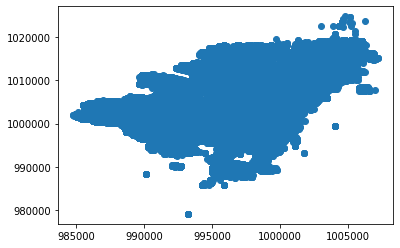

In [12]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=14,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- One realization
- Average time elapsed for realization: 1 hour
- memory error

#### Parameter = 288

TimeStamps
<class 'pandas.core.series.Series'>
[0        2017-03-02 00:03:00
2        2017-02-01 15:45:00
3        2017-02-07 08:20:00
4        2017-02-10 13:51:00
5        2017-02-25 11:20:00
                 ...        
708442   2017-03-30 19:11:00
708443   2017-03-30 08:49:00
708450   2017-03-30 19:14:00
708451   2017-03-30 18:02:00
708452   2017-03-30 10:47:00
Name: FECHA_HORA_TS, Length: 91672, dtype: datetime64[ns]]
time BW set on:  288
space BW set on:  50


MemoryError: Unable to allocate array with shape (1, 91672, 85747) and data type float64

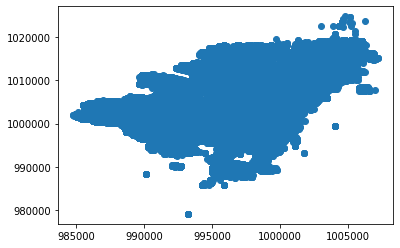

In [18]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=288,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 1
- Average time elapsed for realization: 2.4 hours
- Type of error: memory error

#### Parameter = 576

In [ ]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=576,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

TimeStamps
<class 'pandas.core.series.Series'>
[0        2017-03-02 00:03:00
2        2017-02-01 15:45:00
3        2017-02-07 08:20:00
4        2017-02-10 13:51:00
5        2017-02-25 11:20:00
                 ...        
708442   2017-03-30 19:11:00
708443   2017-03-30 08:49:00
708450   2017-03-30 19:14:00
708451   2017-03-30 18:02:00
708452   2017-03-30 10:47:00
Name: FECHA_HORA_TS, Length: 91672, dtype: datetime64[ns]]
time BW set on:  576
space BW set on:  50


- Number of realizations: 1
- Average time elapsed for realization: 2.5 hours
- Type of error: memory error

#### Parameter = 1440

TimeStamps
<class 'pandas.core.series.Series'>
[0        2017-03-02 00:03:00
2        2017-02-01 15:45:00
3        2017-02-07 08:20:00
4        2017-02-10 13:51:00
5        2017-02-25 11:20:00
                 ...        
708442   2017-03-30 19:11:00
708443   2017-03-30 08:49:00
708450   2017-03-30 19:14:00
708451   2017-03-30 18:02:00
708452   2017-03-30 10:47:00
Name: FECHA_HORA_TS, Length: 91672, dtype: datetime64[ns]]
time BW set on:  1440
space BW set on:  50


MemoryError: Unable to allocate array with shape (91672, 91672) and data type float64

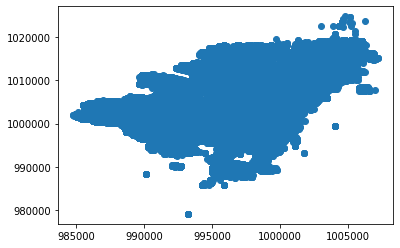

In [17]:
localidad = 'city'
city_predictor = trainModel_parameters(df,localidad,initial_date, final_date,time_bw=1440,space_bw=50)
city_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+str(localidad)+'_'+initial_date+'_'+final_date+'.pkl','wb')
pickle.dump(city_predictor, city_outfile)
city_outfile.close() 

Results: 
- Number of realizations: 5
- Average time elapsed for realization: 20 minutes
- memory error